##  Introduction: 

In this project, we will build a predictive model to perform binary classification on the dataset provided in "binary_classification_ds.csv".

I have used Scikit-learn in Python for data preprocessing and evaluation, and XGBoost to perform classification.

Let us start out by importing the necessary modules:

In [1]:
%matplotlib inline
from __future__ import division
from math import floor
import codecs
from collections import OrderedDict
import numpy as np
import itertools
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, make_scorer, fbeta_score
import matplotlib.pyplot as plt

/Library/Python/2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Python/2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Loading the Data

Now that the required modules have been imported, we can load the data and proceed with the next steps:

In [2]:
def read_data(input_file_name):
    """reads CSV file and maps data to a dictionary where:
    - key: the unique identifier (id)
    - value: tuple in the form of: 
    ([feature_col_1 feature_col_2 ... feature_col_n], target)
    """
    with codecs.open(input_file_name,'r') as in_file:
        data_dict = OrderedDict()
        in_file.readline() #skip the first line, i.e. column headings
        for line in in_file:
            row = line.strip().split(",")
            target = int(row[-1])
            feature_cols = row[1:-1]
            features = [float(feat_val) for feat_val in feature_cols]
            data_dict[row[0]] = features, target
    print 'Successfully loaded data!'
    return data_dict

In [3]:
#load data
input_file_name = 'binary_classification_ds.csv'
data_dict = read_data(input_file_name)

Successfully loaded data!


## Preprocessing

With the dataset successfully loaded, we can go about creating the features and labels in the format expected by Scikit-learn:

In [14]:
#read data from the dictionary and create features and labels for classification
def create_feature_matrix(data_dict):
    X = [] #list of features
    Y = [] #list of labels
    for key in data_dict:
        X.append(data_dict[key][0])
        Y.append(data_dict[key][1])
    X = np.array(X)
    #Y = np.array(Y)
    return X, Y

In [15]:
#create features and labels
X, Y = create_feature_matrix(data_dict)
print 'There are %d observations and %d features' % (X.shape[0], X.shape[1])

There are 50000 observations and 102 features


### Data Split

Next, data needs to be split into train and test portions. Since project instruction has not hinted on any specific splitting procedure, I have performed a random split with the test portion ratio of 0.33 (which is a standard split method in sklearn), as follows:

In [16]:
#perform random train-test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=0)
print 'Train data consists of %d observations' % (X_train.shape[0])
print 'Test data consists of %d observations' % (X_test.shape[0])

Train data consists of 33500 observations
Test data consists of 16500 observations


Let's take a look at the training data and see what the ratio of the two class populations is in the training set:

In [26]:
nnz_train = np.count_nonzero(y_train) #class 1 population
nz_train = len(y_train) - nnz_train #class 0 population
class_0_ratio = 100* (nz_train / len(y_train))
class_1_ratio = 100* (nnz_train / len(y_train))
print '%0.2f percent of training data belong to class 0' % (class_0_ratio)
print '%0.2f percent of training data belong to class 1' % (class_1_ratio)

96.63 percent of training data belong to class 0
3.37 percent of training data belong to class 1


### Insight into the Data

The numbers above mean that the dataset is highly imbalanced, with one class populating less than 4% of the training set!!

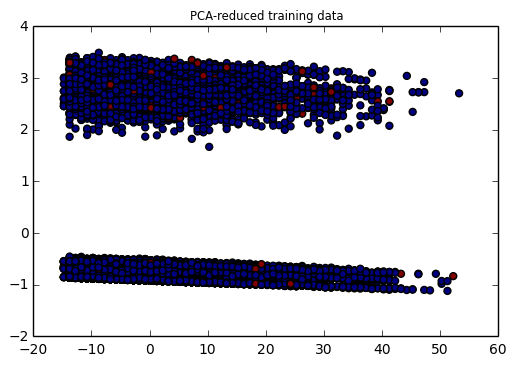

In [18]:
#apply PCA to training data for visualization purposes
pca = PCA(n_components=2)
X_r = pca.fit(X_train).transform(X_train)
plt.figure()
plt.title("PCA-reduced training data", fontsize='small')
plt.scatter(X_r[:, 0], X_r[:, 1], marker='o', c=y_train, s=25, edgecolor='k', label='Luck')

PCA dimension reduction technique has been applied to data for visualization purposes only. By reducing the dimension of data to two, we can visualize the data points in a 2-D scatter plot (ss shown). The scatter plot also visually verifies that the blue class (class 0) is way more dominant in the training data compared to the red class (class 1). Let's take a look at the test set now and see if we observe a similar pattern (given that the splitting of data into train and test was performed randomly, we are expecting to see a similar pattern in the test set as well:

In [19]:
nnz_test = np.count_nonzero(y_test) #class 1 population
nz_test = len(y_test) - nnz_test #class 0 population
class_0_ratio = 100* (nz_test / len(y_test))
class_1_ratio = 100* (nnz_test / len(y_test))
print '%0.2f percent of test data belong to class 0' % (class_0_ratio)
print '%0.2f percent of test data belong to class 1' % (class_1_ratio)

96.83 percent of test data belong to class 0
3.17 percent of test data belong to class 1


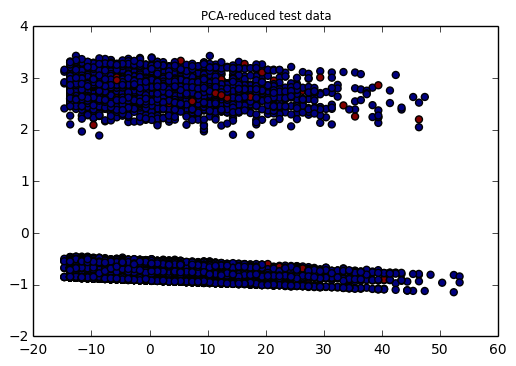

In [20]:
#apply PCA to training data for visualization purposes
pca = PCA(n_components=2)
X_r = pca.fit(X_test).transform(X_test)
plt.figure()
plt.title("PCA-reduced test data", fontsize='small')
plt.scatter(X_r[:, 0], X_r[:, 1], marker='o', c=y_test, s=25, edgecolor='k', label='Luck')

which verifies that both the training and test set are ___highly imbalanced___. Dealing with highly imbalanced datasets introduces its own challenges, and thus it is crucial to pick the right approach (both in __classification__ and __evaluation__) to be able to (1) achieve a good classification performance, and (2) interpret the results in the most meaningful way. I will elaborate more on this later on.

By looking at the data, one can observe that some of the features given in the different columns differ in nature, in other words, feature set is a combination of continuous and categorical variables. For example, the feature appearing in the first feature column (i.e. col_24, col_39) is a continuous feature with actual continuous values while variables corresponding to features appearing in some of the other columns (e.g. col_263, col_264, col_214, ...) seem to be categorical variables with two categories that have been binarized into "0" and "1" values. Other features represent categorical variables of more than two categories (e.g. col_103) with possible values being {0,0.5,1}. This insight about the nature of the features we are dealing with will come in handy later on in some of the next steps.

### Feature Standardization

As a standard next preprocessing step, we standardize all the features using their corresponding mean and standard deviation. The standardization step is particularly essential here due to the combined nature of the features. 
It is worth mentioning that when performing the standardization, we use the mean and standard deviation of features computed only on the training set since we do not want any information from the test set to leak to our model: 

In [22]:
#perform feature standardization
scaler = preprocessing.StandardScaler().fit(X_train) #compute the mean and standard deviation on a training set so as to be able to later reapply the same transformation on the testing set
X_train = scaler.transform(X_train) 
X_test = scaler.transform(X_test) 

Dimension reduction efforts were also made (using PCA with various number of components), but better results were achieved when no dimension reduction was applied.

## Classification

### Discussion on Choices of the Classifier and Evaluation Metric

As discussed earlier, the dataset is highly imbalanced and thus the classifier that we pick needs to be able to deal with this imbalance. Revisiting the two class populations, one can think of the "target" column (to be used as classification labels) as capturing some sort of anomaly since the occurrences of "1"'s are way less frequent than occurrences of "0"s. Thus, one idea could be to actually tackle the problem as an anomaly detection problem. I have not, however, pursued this idea since anomaly detection algorithms lie within the unsupervised learning class of algorithms (or clustering), and we have been asked in the project description to perform ___classification___ on data.

If we are not careful with our choice of the classiffier, we may end up building an inaccurate model that totally ignores the minority class and ends up misclassfiying the data belonging to this (the minority) class. And even worse, if we do not pick the right evaluation metric, we may end up missing this completely. Let's look at a simple example to make this more clear:

Suppose we apply a simple random forest classifier to the training data, and evaluate the performance on the test data using the metric accuracy:

In [23]:
#train the random forest classifier
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
acc = accuracy_score(y_test, preds)
print 'Classification accuracy is: %.4f' % (acc)

Classification accuracy is: 0.9679


We got the accuracy of 96.79%, which looks great. But let's take a closer look at the results by looking at the confusion matrix:

In [24]:
cm = confusion_matrix(y_test, preds)
print 'confusion matrix:'
print(cm)
#print('\n')
print 'classification report:'
print(classification_report(y_test, preds))

confusion matrix:
[[15970     7]
 [  523     0]]
classification report:
             precision    recall  f1-score   support

          0       0.97      1.00      0.98     15977
          1       0.00      0.00      0.00       523

avg / total       0.94      0.97      0.95     16500



As you can see, the classifier ended up misclassifying all the samples from the minority class (class 1), which accuracy was not able to capture at all. While precision and recall for the majority class are near-perfect, we are getting zero precision and recall for class 1. Coming back to the discussion earlier on anomaly detection, in this case, the classifier could not detect any anomalies, which is way too far from ideal. The reason why we got high accuracy at first place was that the classifier had a lot of true positives on class 0, which make up for the bigger population in the whole dataset as well.

Thus, for my choice of the evaluation metric, I have focused on the following:
* precision, recall and F-1 score
* ROC curve and the Area Under the Curve (AUC measure)

As for my choice of classifier, I have used the Extreme Gradient Boosting (xgboost) algorithm, for the following main reasons:
* xgboost belongs to the family of boosting algorithms, which tend to be more useful (compared to bagging or non-ensemble methods) in scenarios where class imbalance is present in the training set since these algorithms will iteratively assign larger weights to the class that keeps getting misclassified by the weak learners (the minority class in this case).
* xgboost uses an ensemble of decision tree learners, which is a good choice of classifier when features are a mix of continuous and binarized.
* With xgboost, you can have control over the balance of positive and negative weights (via parameter __scale_pos_weight__), which comes in handy for unbalanced classes.
* Compared to GBM, xgboost is much faster and more efficient computationally. Plus it is more robust to overfitting. In other words, there are several parameters that you can tune which allows for model complexity control.

Although having many parameters to tune, gives xgboost the flexibility and power to avoid over/under-fitting, this can also be considered a downside of the algorithm since a lot of hyperparameter tuning may be required.

With this discussion, let's proceed with the hyperparameter tuning.

### Hyperparameter Tuning

As for the parameter to control class balance, we can manually compute the value based on the frequency of the two classes in training data:

In [29]:
class_ratio = floor(nz_train / nnz_train)
class_ratio

28.0

There are two other parameters in xgboost that play important roles in avoiding under/over-fitting. We have used K-fold cross-validation to tune these parameters:

In [39]:
# Parameter Tuning
model = XGBClassifier(random_state=0)
cv_params = {"max_depth": [1,2,4,6],
             "min_child_weight" : [1,2,4,5]}
grid_search = GridSearchCV(model, cv_params, cv = 3, scoring = 'roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=2, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Parameters have been tuned. Let's build the classifier using the tuned parameter values:

In [40]:
#train the classifier
#clf = RandomForestClassifier(class_weight="balanced", random_state=0)
#clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)

clf = XGBClassifier(min_child_weight=2 , max_depth=2, scale_pos_weight=class_ratio, random_state=0)
clf.fit(X_train, y_train)

#clf = LDA(priors=np.array([0.96,0.04]))
### SVM
#clf = CalibratedClassifierCV(LinearSVC(class_weight={1: 30}, random_state=0))
#wclf = svm.LinearSVC(class_weight={1: 30})
#wclf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=2, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=28.0, seed=None,
       silent=True, subsample=1)

## Evaluation

Now let's use the trained classifier to make predictions on the test set:

In [41]:
preds = clf.predict(X_test)

It is time for evaluation:

* __Accuracy__

In [33]:
acc = accuracy_score(y_test, preds)
print 'Classification accuracy is: %.4f' % (acc)

Classification accuracy is: 0.6432


Although the accuracy is lower than the previous case, we know how this measure is not a good representative of the classifier performance.

* __Confusion Matrix & Precision, Recall and F-1 Score__

In [34]:
cm = confusion_matrix(y_test, preds)
print 'confusion matrix:'
print(cm)
#print('\n')
print 'classification report:'
print(classification_report(y_test, preds))

confusion matrix:
[[10295  5682]
 [  205   318]]
classification report:
             precision    recall  f1-score   support

          0       0.98      0.64      0.78     15977
          1       0.05      0.61      0.10       523

avg / total       0.95      0.64      0.76     16500



The small precision for the minority class (class 1) is due to the relatively-much-bigger population of the majority class, which results in the true positive value for class 1 (i.e. 318) being much smaller than the corresponding false positive value (5682), and thus the small precision for class 1. Which overall makes the AUC score or the average F-1 score better measures to use in evaluation in case of class imbalance.

In [43]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="red")
                 #color="red" if cm[i, j] > thresh else "black")
    #plt.set_tight_layout(True)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[ 0.64436377  0.35563623]
 [ 0.39196941  0.60803059]]


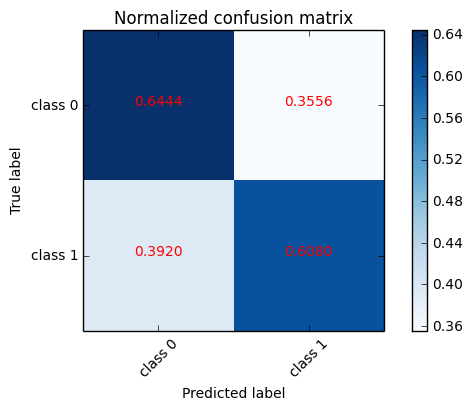

In [44]:
plot_confusion_matrix(cm, classes=['class 0', 'class 1'], normalize=True, title='Normalized confusion matrix')

* __ROC & AUC__

Let's analyze the ROC curve now:

In [49]:
def plot_roc_curve(model, X_test, Y_test):
    probas_ = model.predict_proba(X_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(Y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC Curve (AUC = %0.2f)' % (roc_auc))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

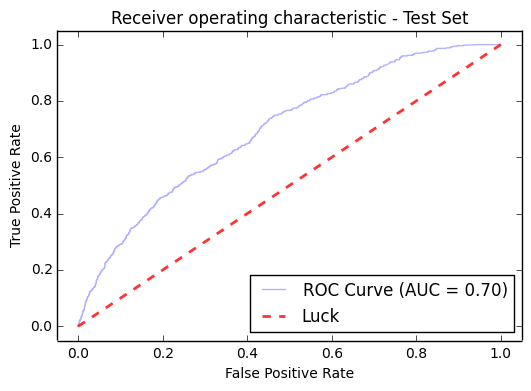

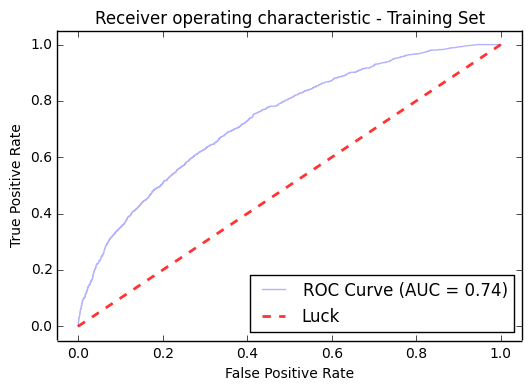

In [51]:
plt.title('Receiver operating characteristic - Test Set')
plot_roc_curve(clf,X_test,y_test)
plt.title('Receiver operating characteristic - Training Set')
plot_roc_curve(clf,X_train,y_train)

* __Discussion on Overfitting & Underfitting__

I have also plotted the ROC curve on the training set as a proof that there is no overfitting to training data happening (since the AUC values achieved on the training and test data are close), and thus our model has small enough variance. A F-1 score of 76% and an AUC score of 0.70 is achieved on test data, and thus the model is not too simple which means there is low bias (and not under-fitting).